This is just california house with grid search added..

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from modules.BatchPitNormalization import BatchPitNorm1d
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")


Using cuda device


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = np.genfromtxt('../data/housing.csv', delimiter=",",skip_header=1)

data = np.delete(data, [-1], axis=1)


X = data[:,:8]
Y = data[:,8].reshape(-1,1)



Y=Y[~np.isnan(X).any(axis=1)]
X=X[~np.isnan(X).any(axis=1)]

print(np.mean(Y))

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)

scalerX = StandardScaler()
scalerY = StandardScaler()
# scale
scaler_x = scalerX.fit(X_train_raw)
scaler_y = scalerY.fit(y_train_raw)

X_train = scaler_x.transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1,1)



206864.41315519012


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
#baseline with ordinary least squares Linear Regression
X_train_bl = X_train.detach().cpu().numpy()
Y_train_bl = y_train.detach().cpu().numpy()
x_test_bl = X_test.detach().cpu().numpy()
y_test_bl = y_test.detach().cpu().numpy()
reg = LinearRegression().fit(X_train_bl, Y_train_bl)
reg.score(X_train_bl,Y_train_bl)
y_pred_bl = reg.predict(x_test_bl)
y_pred_bl = scaler_y.inverse_transform(y_pred_bl)
y_test_bl = scaler_y.inverse_transform(y_test_bl)
print("R2-score: ", r2_score(y_test_bl,y_pred_bl))
print("MAE:", mean_absolute_error(y_test_bl,y_pred_bl))
print("RMSE:", root_mean_squared_error(y_test_bl,y_pred_bl))

R2-score:  0.6461830717065418
MAE: 50475.13
RMSE: 68968.016


In [4]:
#without bn
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [5]:
#with bn on first
class NeuralNetwork_bn(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_bn, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x
    
class NeuralNetwork_bn2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_bn2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [6]:
# with batch pit
class NeuralNetwork_pit(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
class NeuralNetwork_pit2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
class NeuralNetwork_pit3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,num_pit_samples,take_num_samples_when_full,normal_backtransform,trainable_bandwidth):
        super(NeuralNetwork_pit3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=num_pit_samples,dev=device,take_num_samples_when_full=take_num_samples_when_full,normal_backtransform=normal_backtransform,trainable_bandwidths=trainable_bandwidth),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
def get_train_test_data(X,Y,grid_search: bool=False):
    if grid_search:
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, random_state=1)
    else:
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)
    #scalers
    scaler_x = StandardScaler().fit(X_train_raw)
    scaler_y = StandardScaler().fit(y_train_raw)

    #scale data
    X_train = scaler_x.transform(X_train_raw)
    X_test = scaler_x.transform(X_test_raw)
    y_train = scaler_y.transform(y_train_raw)
    y_test = scaler_y.transform(y_test_raw)
    #make tensors
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1,1)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1,1)

    return X_train, y_train, X_test, y_test, scaler_x, scaler_y

In [8]:
def train_model(model,grid_search: bool=False):
    X_train,y_train,X_test,y_test,scaler_x,scaler_y = get_train_test_data(X,Y,grid_search)
    
    input_size = 8
    hidden_size = 32
    num_classes = 1
    learning_rate = 0.001 
    n_epochs = 30 
    batch_size = 64
    model.to(device)
    model.cuda()
    lossFunction = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for Xbatch, ybatch in loader:
            
            y_pred = model(Xbatch)
            loss = lossFunction(y_pred, ybatch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()

    model.eval()
    y_pred_eval = model(X_test)
    y_pred_eval = y_pred_eval.detach().cpu().numpy()
    y_pred_scaled = scaler_y.inverse_transform(y_pred_eval)
    y_test_eval = y_test.detach().cpu().numpy()
    y_test_scaled = scaler_y.inverse_transform(y_test_eval)
    r2 = r2_score(y_test_scaled,y_pred_scaled)
    mae = mean_absolute_error(y_test_scaled,y_pred_scaled)
    rmse = root_mean_squared_error(y_test_scaled,y_pred_scaled)
    #print("R2-score: ",r2)
    #print("MAE: ", mae)
    #print("RMSE: ", rmse)
    return r2, mae,rmse

In [9]:
import pandas as pd
def grid_search():
    from itertools import product
    # Hyperparameter grid
    param_grid = {
        'num_pit_samples': [50, 100, 150, 250, 500, 1000],
        'take_num_samples_when_full': [0, 1, 2, 3, 5, 10],
        'normal_backtransform': [True, False],
        'trainable_bandwidths': [True, False]
    }
    results = np.array(("mae","r2","num_pit_samples","take_num_samples_when_full","normal_backtransform","trainable_bandwidth","model_id"))
    model_id = "model 3"
    hidden_size = 32
    input_size = 8
    num_classes = 1
    best_params = []

    for params in product(*param_grid.values()):
        num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
        model = NeuralNetwork_pit3(input_size=input_size,
                                hidden_size=hidden_size,
                                num_classes=num_classes,
                                num_pit_samples=num_pit_samples,
                                normal_backtransform=normal_backtransform,
                                take_num_samples_when_full=take_num_samples_when_full,
                                trainable_bandwidth=trainable_bandwidths
                                )
        # train model
        try:
            r2, mae,rmse = train_model(model,grid_search=True)
            
            if best_params == []:
                best_params.append(mae)
                best_params.append(params)
            elif mae < best_params[0]:
                best_params[0] = mae
                best_params[1] = params

            grid_res = np.array((mae,r2, params[0],params[1],params[2],params[3],model_id))
            results = np.vstack((results,grid_res))
            print(best_params, params, mae)
            #print(results)
        except:
            return results
    print("best!!! ", best_params)
    return results

results_grid = grid_search()

# convert array into dataframe 
DF = pd.DataFrame(results_grid) 
  
# save the dataframe as a csv file 
DF.to_csv("cal_house_model3.csv")

/tmp/ipykernel_374060/3841915876.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[35582.62, (50, 0, True, True)] (50, 0, True, True) 35582.62
[35582.62, (50, 0, True, True)] (50, 0, True, False) 36169.01
[35582.62, (50, 0, True, True)] (50, 0, False, True) 37960.055
[35023.625, (50, 0, False, False)] (50, 0, False, False) 35023.625
[35023.625, (50, 0, False, False)] (50, 1, True, True) 43695.707
[35023.625, (50, 0, False, False)] (50, 1, True, False) 42495.266
[35023.625, (50, 0, False, False)] (50, 1, False, True) 42405.695
[35023.625, (50, 0, False, False)] (50, 1, False, False) 42713.86
[35023.625, (50, 0, False, False)] (50, 2, True, True) 45785.855
[35023.625, (50, 0, False, False)] (50, 2, True, False) 43800.953
[35023.625, (50, 0, False, False)] (50, 2, False, True) 48556.65
[35023.625, (50, 0, False, False)] (50, 2, False, False) 59419.67
[35023.625, (50, 0, False, False)] (50, 3, True, True) 47012.55
[35023.625, (50, 0, False, False)] (50, 3, True, False) 48849.676
[35023.625, (50, 0, False, False)] (50, 3, False, True) 48753.94
[35023.625, (50, 0, False, 

Grid_search ~59 min: best_barams = (250, 0, True, True)

model 2: [35626.812, (500, 2, True, True)]

In [ ]:
model_1 = NeuralNetwork(8,32,1)
r21_l,mae1_l = [],[]
model_2 = NeuralNetwork_bn(8,32,1)
r22_l,mae2_l = [],[]
model_3 = NeuralNetwork_bn2(8,32,1)
r23_l,mae3_l = [],[]
model_4 = NeuralNetwork_pit(input_size = 8,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=150,
                            take_num_samples_when_full=0,
                            normal_backtransform=True,
                            trainable_bandwidth=True)
r24_l,mae4_l = [],[]
model_5 = NeuralNetwork_pit2(input_size = 8,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=500,
                            take_num_samples_when_full=0,
                            normal_backtransform=True,
                            trainable_bandwidth=True)
r25_l,mae5_l = [],[]
model_6 = NeuralNetwork_pit3(input_size = 8,
                            hidden_size = 32,
                            num_classes = 1,
                            num_pit_samples=150,
                            take_num_samples_when_full=0,
                            normal_backtransform=True,
                            trainable_bandwidth=True)
r26_l,mae6_l = [],[]

for i in range(7):
    r2_1,mae1 = train_model(model_1)
    r2_2,mae2 = train_model(model_2)
    r2_3,mae3 = train_model(model_3)
    r2_4,mae4 = train_model(model_4)
    r2_5,mae5 = train_model(model_5)
    r2_6,mae6 = train_model(model_6)

    r21_l.append(r2_1)
    mae1_l.append(mae1)
    r22_l.append(r2_2)
    mae2_l.append(mae2)
    r23_l.append(r2_3)
    mae3_l.append(mae3)
    r24_l.append(r2_4)
    mae4_l.append(mae4)
    r25_l.append(r2_5)
    mae5_l.append(mae5)
    r26_l.append(r2_6)
    mae6_l.append(mae6)

In [ ]:
R2_list = []
MAE_list = []
RMSE_list = []
R2_list_bn = []
MAE_list_bn = []
RMSE_list_bn = []
R2_list_pit = []
MAE_list_pit = []
RMSE_list_pit = []

for i in range(10):

    r2,mae,rmse = train_model(NeuralNetwork(input_size = 8, hidden_size = 32, num_classes = 1))
    r2_bn,mae_bn,rmse_bn = train_model(NeuralNetwork_bn(input_size = 8, hidden_size = 32, num_classes = 1))
    R2_pit,mae_pit,rmse_pit = train_model(NeuralNetwork_pit(input_size = 8,
                                                            hidden_size = 32,
                                                            num_classes = 1,
                                                            num_pit_samples=250,
                                                            take_num_samples_when_full=0,
                                                            normal_backtransform=True,
                                                            trainable_bandwidth=True))
    # no bn
    R2_list.append(r2)
    MAE_list.append(mae)
    RMSE_list.append(rmse)
    # ordinary bn
    R2_list_bn.append(r2_bn)
    MAE_list_bn.append(mae_bn)
    RMSE_list_bn.append(rmse_bn)
    # pit
    R2_list_pit.append(R2_pit)
    MAE_list_pit.append(mae_pit)
    RMSE_list_pit.append(rmse_pit)



Text(0.5, 1.0, 'RMSE')

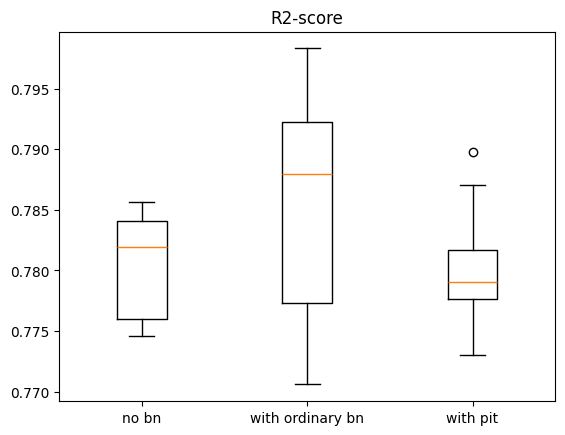

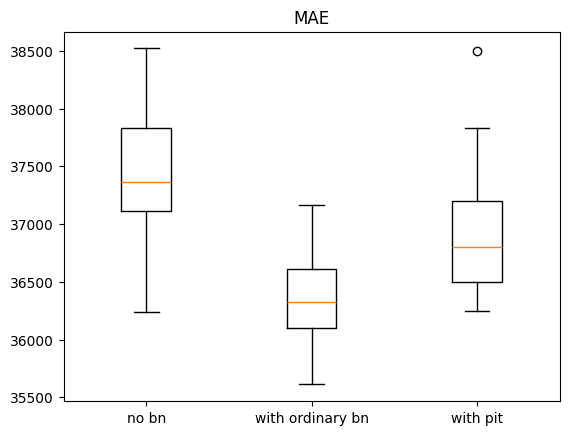

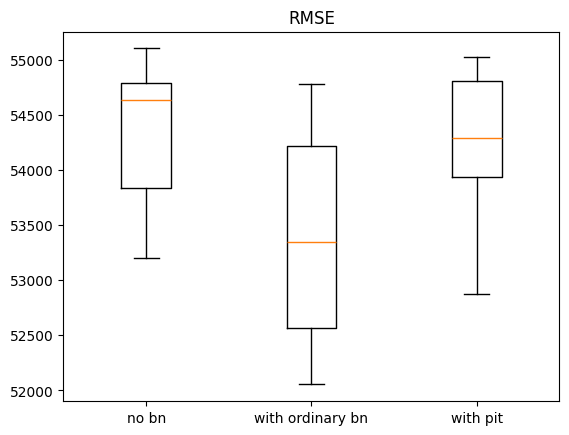

In [ ]:
plt.boxplot([R2_list,R2_list_bn,R2_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("R2-score")
plt.figure()
plt.boxplot([MAE_list,MAE_list_bn,MAE_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("MAE")
plt.figure()
plt.boxplot([RMSE_list,RMSE_list_bn,RMSE_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("RMSE")